In [120]:
import itertools
import textwrap

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sbn
from disjoint_set import DisjointSet
from mbi import FactoredInference, Dataset, Domain
from scipy import sparse
from scipy.special import logsumexp
from sklearn.preprocessing import OrdinalEncoder

from cdp2adp import cdp_rho


sbn.set_style("ticks")

In [2]:
"""
Taken from https://github.com/ryan112358/private-pgm/blob/master/mechanisms/mst.py

This is a generalization of the winning mechanism from the 
2018 NIST Differential Privacy Synthetic Data Competition.

Unlike the original implementation, this one can work for any discrete dataset,
and does not rely on public provisional data for measurement selection.  
"""


def MST(data, epsilon, delta):
    rho = cdp_rho(epsilon, delta)
    sigma = np.sqrt(3 / (2 * rho))
    cliques = [(col,) for col in data.domain]
    log1 = measure(data, cliques, sigma)
    data, log1, undo_compress_fn = compress_domain(data, log1)
    cliques = select(data, rho / 3.0, log1)
    log2 = measure(data, cliques, sigma)
    engine = FactoredInference(data.domain, iters=5000)
    est = engine.estimate(log1 + log2)
    synth = est.synthetic_data()
    return undo_compress_fn(synth)


def measure(data, cliques, sigma, weights=None):
    if weights is None:
        weights = np.ones(len(cliques))
    weights = np.array(weights) / np.linalg.norm(weights)
    measurements = []
    for proj, wgt in zip(cliques, weights):
        x = data.project(proj).datavector()
        y = x + np.random.normal(loc=0, scale=sigma / wgt, size=x.size)
        Q = sparse.eye(x.size)
        measurements.append((Q, y, sigma / wgt, proj))
    return measurements


def compress_domain(data, measurements):
    supports = {}
    new_measurements = []
    for Q, y, sigma, proj in measurements:
        col = proj[0]
        sup = y >= 3 * sigma
        supports[col] = sup
        if supports[col].sum() == y.size:
            new_measurements.append((Q, y, sigma, proj))
        else:  # need to re-express measurement over the new domain
            y2 = np.append(y[sup], y[~sup].sum())
            I2 = np.ones(y2.size)
            I2[-1] = 1.0 / np.sqrt(y.size - y2.size + 1.0)
            y2[-1] /= np.sqrt(y.size - y2.size + 1.0)
            I2 = sparse.diags(I2)
            new_measurements.append((I2, y2, sigma, proj))
    undo_compress_fn = lambda data: reverse_data(data, supports)
    return transform_data(data, supports), new_measurements, undo_compress_fn


def exponential_mechanism(q, eps, sensitivity, prng=np.random, monotonic=False):
    coef = 1.0 if monotonic else 0.5
    scores = coef * eps / sensitivity * q
    probas = np.exp(scores - logsumexp(scores))
    return prng.choice(q.size, p=probas)


def select(data, rho, measurement_log, cliques=[]):
    engine = FactoredInference(data.domain, iters=1000)
    est = engine.estimate(measurement_log)

    weights = {}
    candidates = list(itertools.combinations(data.domain.attrs, 2))
    for a, b in candidates:
        xhat = est.project([a, b]).datavector()
        x = data.project([a, b]).datavector()
        weights[a, b] = np.linalg.norm(x - xhat, 1)

    T = nx.Graph()
    T.add_nodes_from(data.domain.attrs)
    ds = DisjointSet()

    for e in cliques:
        T.add_edge(*e)
        ds.union(*e)

    r = len(list(nx.connected_components(T)))
    epsilon = np.sqrt(8 * rho / (r - 1))
    for i in range(r - 1):
        candidates = [e for e in candidates if not ds.connected(*e)]
        wgts = np.array([weights[e] for e in candidates])
        idx = exponential_mechanism(wgts, epsilon, sensitivity=1.0)
        e = candidates[idx]
        T.add_edge(*e)
        ds.union(*e)

    return list(T.edges)


def transform_data(data, supports):
    df = data.df.copy()
    newdom = {}
    for col in data.domain:
        support = supports[col]
        size = support.sum()
        newdom[col] = int(size)
        if size < support.size:
            newdom[col] += 1
        mapping = {}
        idx = 0
        for i in range(support.size):
            mapping[i] = size
            if support[i]:
                mapping[i] = idx
                idx += 1
        assert idx == size
        df[col] = df[col].map(mapping)
    newdom = Domain.fromdict(newdom)
    return Dataset(df, newdom)


def reverse_data(data, supports):
    df = data.df.copy()
    newdom = {}
    for col in data.domain:
        support = supports[col]
        mx = support.sum()
        newdom[col] = int(support.size)
        idx, extra = np.where(support)[0], np.where(~support)[0]
        mask = df[col] == mx
        if extra.size == 0:
            pass
        else:
            df.loc[mask, col] = np.random.choice(extra, mask.sum())
        df.loc[~mask, col] = idx[df.loc[~mask, col]]
    newdom = Domain.fromdict(newdom)
    return Dataset(df, newdom)

In [3]:
def encode_data(data):
    """Use an ordinal encoder to convert categorical data."""

    encoder = OrdinalEncoder().fit(data)
    data = pd.DataFrame(encoder.transform(data).astype(int), columns=data.columns)

    return data, encoder


def load_data(path, skip=1):
    """Read in and prepare the data for synthesis."""

    data = pd.read_csv(path, skiprows=skip).drop("Person ID", axis=1)
    data, encoder = encode_data(data)

    return data, encoder


def decode_data(data, encoder):
    """Decode the data so it is interpretable."""

    return pd.DataFrame(encoder.inverse_transform(data), columns=data.columns)


def get_sparse_column_pair(data):
    """Get the column pair with the lowest two-way marginal count."""

    pair = None
    min_cell_count = np.inf
    for a, b in itertools.combinations(data.columns, r=2):
        count = data.groupby([a, b]).size().min()
        if count < min_cell_count:
            min_cell_count = count
            pair = [a, b]

    return pair


def calculate_marginal_table(data, by, encoder=None):
    """Get a marginal table for a column or set thereof."""

    if encoder is not None:
        data = data.pipe(decode_data, encoder)

    table = data.groupby(by).size().rename("count").reset_index()

    if not isinstance(by, str) and len(by) > 1:
        table = table.pivot(*by, "count")

    return table

In [4]:
data, encoder = load_data("main.csv")
a, b = pair = get_sparse_column_pair(data)

np.random.seed(0)
epsilon, delta = 1, 10 ** -np.ceil(np.log10(len(data)))
dataset = Dataset(data, Domain.fromdict(data.nunique().to_dict()))

In [5]:
rho = cdp_rho(epsilon, delta)
sigma = np.sqrt(3 / (2 * rho))
cliques = [(col,) for col in dataset.domain]
log1 = measure(dataset, cliques, sigma)
dataset, log1, undo_compress_fn = compress_domain(dataset, log1)

cliques = select(dataset, rho / 3.0, log1, cliques=[tuple(pair)])
log2 = measure(dataset, cliques, sigma)

engine = FactoredInference(dataset.domain, iters=5000)
est = engine.estimate(log1 + log2)
synth = est.synthetic_data()

## Data preview

In [6]:
data.pipe(decode_data, encoder).head()

,Region,Residence Type,Family Composition,Population Base,Sex,Age,Marital Status,Student,Country of Birth,Health,Ethnic Group,Religion,Economic Activity,Occupation,Industry,Hours worked per week,Approximated Social Grade
0,E12000001,H,2,1,2,6,2,2,1,2,1,2,5,8,2,-9,4
1,E12000001,H,5,1,1,4,1,2,1,1,1,2,1,8,6,4,3
2,E12000001,H,3,1,2,4,1,2,1,1,1,1,1,6,11,3,4
3,E12000001,H,3,1,2,2,1,2,1,2,1,2,1,7,7,3,2
4,E12000001,H,3,1,1,5,4,2,1,1,1,2,1,1,4,3,2


In [7]:
synth.df.pipe(decode_data, encoder).head()

,Region,Residence Type,Family Composition,Population Base,Sex,Age,Marital Status,Student,Country of Birth,Health,Ethnic Group,Religion,Economic Activity,Occupation,Industry,Hours worked per week,Approximated Social Grade
0,E12000003,H,5,1,1,1,1,1,1,1,1,2,-9,-9,-9,-9,-9
1,W92000004,H,5,1,1,4,1,2,1,1,1,1,1,5,3,3,3
2,E12000007,H,2,1,1,8,2,2,1,1,1,1,5,5,3,-9,2
3,W92000004,H,2,1,1,6,2,2,1,3,1,2,5,9,10,-9,2
4,W92000004,H,2,1,2,2,1,1,1,1,1,1,6,6,11,-9,3


## One-way marginals

In [232]:
def get_noisy_one_way(log1, col):
    """Get the noisy marginal table for a column."""

    noisy = (
        pd.DataFrame(
            {
                "noisy_count": next(
                    counts for _, counts, _, clique in log1 if clique == (col,)
                )
            }
        )
        .rename_axis(index=col)
        .reset_index()
    )

    return noisy


def compare_one_ways(data, log1, synth, col):
    """Get a table comparing all the various one-way tables."""

    original = data.pipe(calculate_marginal_table, col).rename(
        {"count": "observed_count"}, axis=1
    )
    noisy = get_noisy_one_way(log1, col)
    synthetic = synth.df.pipe(calculate_marginal_table, col).rename(
        {"count": "synthetic_count"}, axis=1
    )

    comparison = original.merge(noisy, on=col).merge(synthetic, on=col).set_index(col)
    comparison.index += 1

    return comparison


def plot_one_way_comparison(data, log1, synth, col):
    """Make a faceted bar plot of the various one-way counts."""

    table = (
        compare_one_ways(data, log1, synth, col)
        .unstack()
        .reset_index()
        .replace("_count", "", regex=True)
    )
    table.columns = ["Origin", col, "Count"]

    grid = sbn.FacetGrid(table, col=col, hue="Origin", palette="crest", sharey=False)
    grid.map(sbn.barplot, "Origin", "Count", order=table["Origin"].unique())
    grid.set(xlabel="")

    for ax in grid.axes.ravel():
        for p in ax.patches:
            value = p.get_height()
            if np.isnan(value):
                continue
            if int(value) == value:
                value = int(value)
            else:
                value = round(value, 2)

            ax.annotate(
                f"{value:,}",
                (p.get_x() + p.get_width() / 2.0, p.get_height()),
                ha="center",
                va="center",
                xytext=(0, -10),
                textcoords="offset points",
                fontsize="small",
                color="#eee",
                # rotation=90,
            )

    return grid

In [233]:
compare_one_ways(data, log1, synth, a)

,observed_count,noisy_count,synthetic_count
Population Base,,,
1,561040,561012.364080,560993
2,6730,6647.393075,6730
3,1971,1992.149094,2002


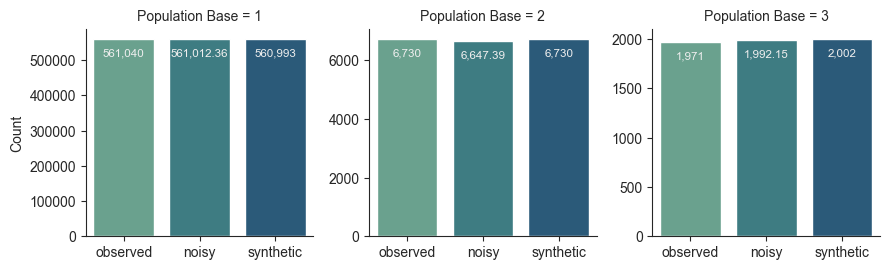

In [234]:
plot_one_way_comparison(data, log1, synth, a)

In [235]:
compare_one_ways(data, log1, synth, b)

,observed_count,noisy_count,synthetic_count
Marital Status,,,
1,270999,270970.273975,270944
2,214180,214115.907498,214146
3,11951,11939.742629,11948
4,40713,40718.058973,40739
5,31898,31937.808435,31948


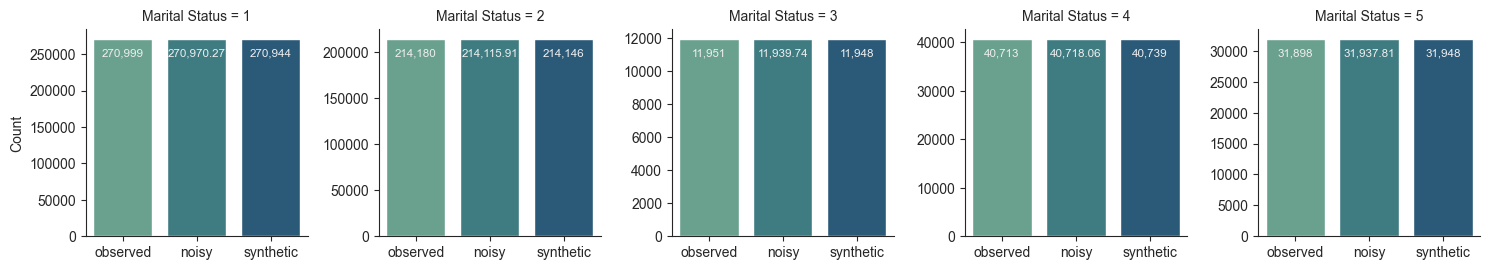

In [236]:
plot_one_way_comparison(data, log1, synth, b)

## Two-way marginals

In [150]:
def get_noisy_two_way(log2, pair, domain):
    """Get the noisy marginal table for a pair of columns."""

    a, b = pair
    shape = domain.project(pair).shape

    noisy = pd.DataFrame(
        next(counts for _, counts, _, clique in log2 if clique == tuple(pair)).reshape(
            shape
        )
    ).rename_axis(index=a, columns=b)

    noisy.index += 1
    noisy.columns += 1

    return noisy

In [151]:
original_pair = calculate_marginal_table(data, pair, encoder)
noisy_pair = get_noisy_two_way(log2, pair, dataset.domain)
synthetic_pair = calculate_marginal_table(synth.df, pair, encoder)

tables = (original_pair, noisy_pair, synthetic_pair)

vmin = np.log(max(1, min(x.min().min() for x in tables)))
vmax = np.log(max(x.max().max() for x in tables))

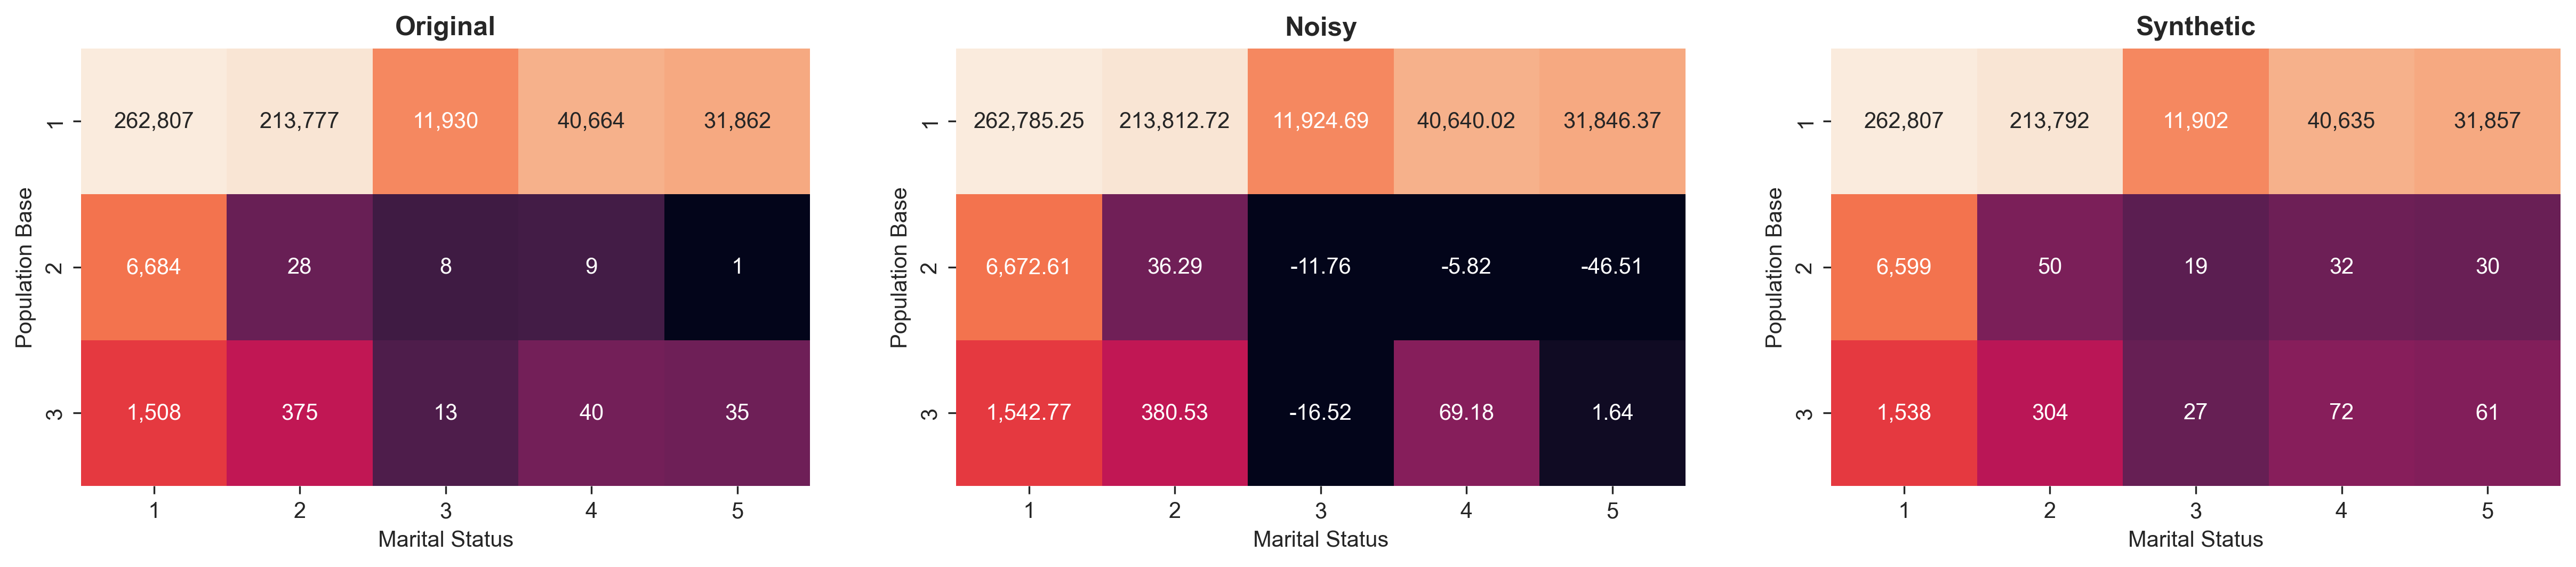

In [152]:
_, axes = plt.subplots(ncols=3, dpi=300, figsize=(20, 8))

for name, table, ax in zip(("Original", "Noisy", "Synthetic"), tables, axes):
    log_table = table.copy()
    log_table[table < 0] = 1
    log_table = np.log(log_table)

    sbn.heatmap(
        log_table,
        annot=table.round(2),
        fmt=",",
        square=True,
        vmin=vmin,
        vmax=vmax,
        cbar=False,
        ax=ax,
    )

    ax.set_title(name, fontdict={"weight": "bold"})

## Synthesis process

The figure below shows a graph mapping out how the synthesis was performed.

Each column is represented as a node, and an edge between two nodes indicates that their two-way marginal
was selected for synthesis. The direction of an edge `(a, b)` indicates that the column `a` is used to
synthesise column `b`.

In this graph, we can see that `Industry` was synthesised first. Then `Industry` was used to synthesise
`Occupation` and so on.

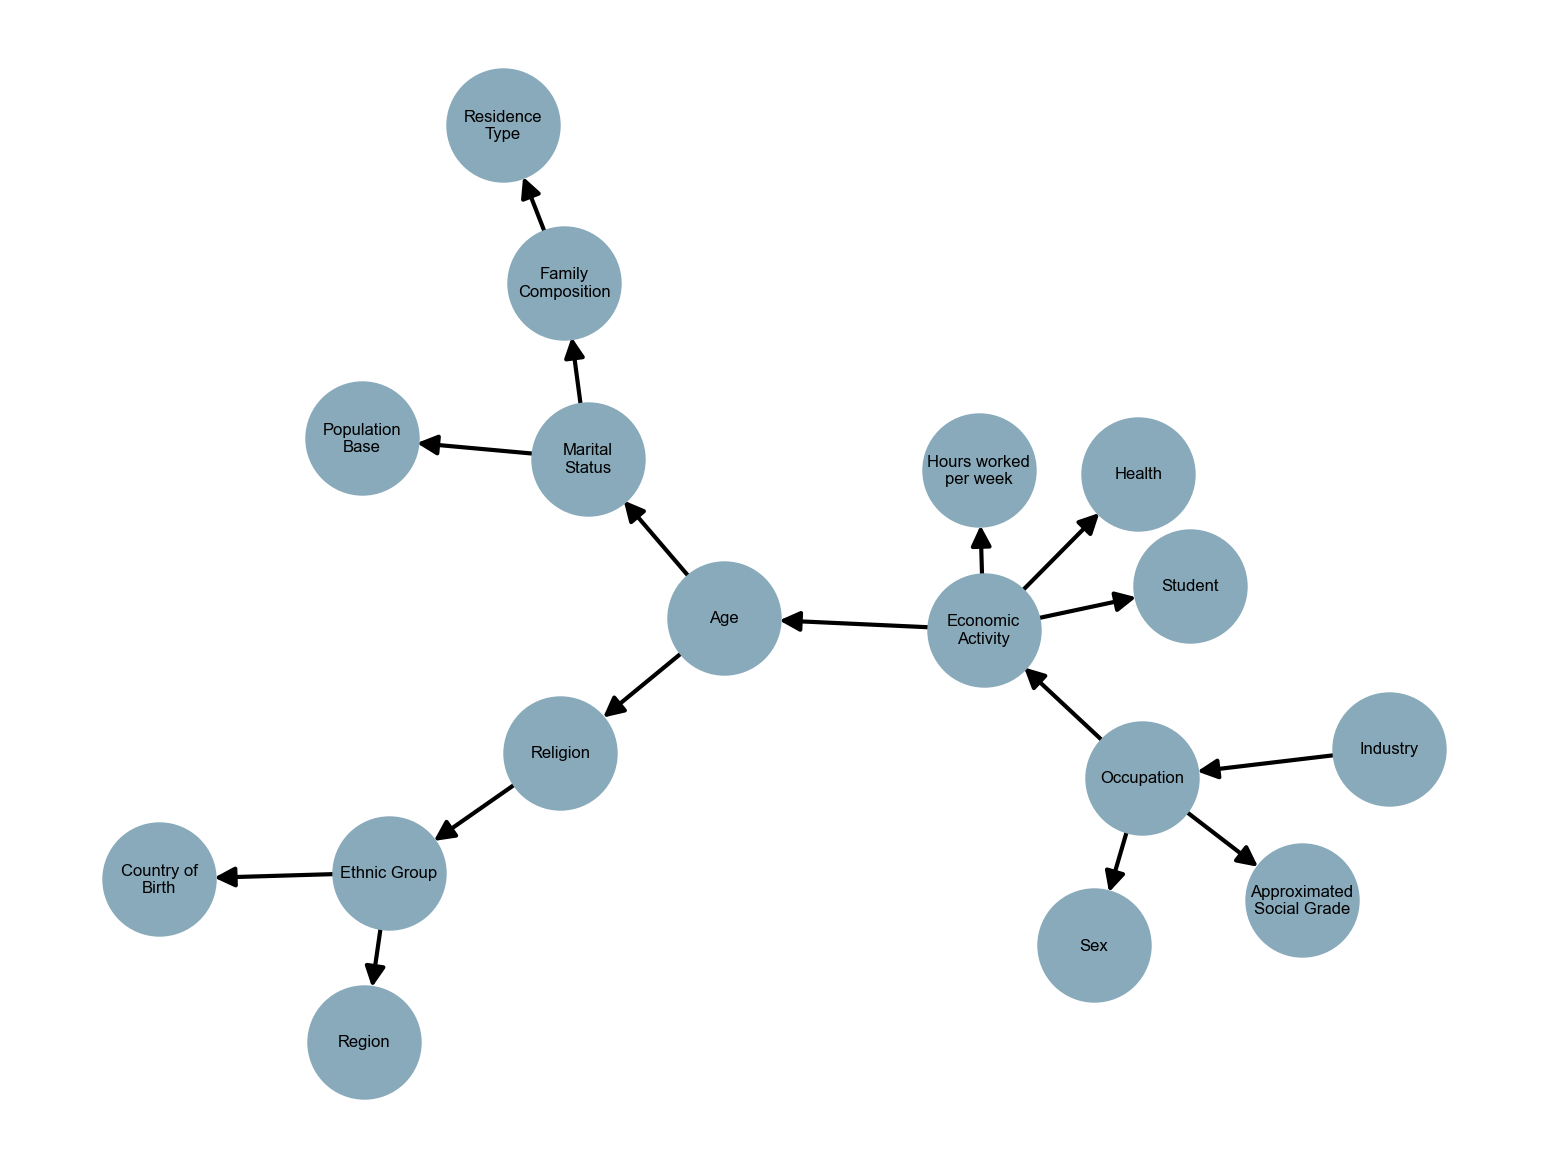

In [239]:
ordered_cliques = [
    sorted(clique, key=est.elimination_order[::-1].index) for clique in cliques
]

wrapped_cliques = [
    tuple(textwrap.fill(col, 12) for col in clique) for clique in ordered_cliques
]

graph = nx.DiGraph()
graph.add_edges_from(wrapped_cliques)
pos = nx.nx_agraph.graphviz_layout(graph, root=est.elimination_order[-1])


_, ax = plt.subplots(dpi=300)
nx.draw(graph, pos, ax=ax, with_labels=True, node_size=700, node_color="#8ab", font_size=4)